In [1]:
import numpy as np
import torch
from connectivity_representation_learning import *

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D  # unused import, required by projection='3d'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Generate 2D Gaussian mixture data

In [2]:
# dimension
d = 2
# number of Gaussians in the mixture
K = 3
# number of points per cluster
N = 500

# for plotting
cmap = plt.get_cmap('gist_rainbow')
cNorm  = mpl.colors.Normalize(vmin=0, vmax=K)
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
colors = scalarMap.to_rgba(range(K))

data = []
labels = []
# random centroids in [-5,5]x[-5, 5]
means = 10*(np.random.rand(K, d)-0.5)
# random covariances
covs = 0.1*np.random.rand(K, d, d)
for k in range(K):
    # this is indeed a covariance matrix
    covs[k] = 0.3*np.dot(covs[k], covs[k].T)+0.7*0.1*np.eye(d)
    data.append([np.random.multivariate_normal(means[k], covs[k], N)])
    labels.append([k,]*N)
    
data = torch.FloatTensor(np.concatenate(data, axis=1).squeeze())
labels = np.array(labels).flatten()

### Model setup

In [3]:
config_layers = {
    'type': 'mlp',
    'input_size': data.shape[1],
    'hidden_size_encoder': 20,
    'hidden_size_decoder': 20,
    'emb_size': 2,
}

use_cuda = False
eta = 2.0
tol = 1e-4
lr = 0.001
batch_size = 50
n_epochs = 10

### Training

In [4]:
model_no_penalty = Model(config_layers, 
                         eta=eta,
                         tol=tol,
                         lr=lr,
                         batch_size=batch_size,
                         use_cuda=use_cuda,
                         connectivity_penalty=0.0,
                        )

model_no_penalty.train(data, n_epochs)
torch.save(model_no_penalty.state_dict(), 'gauss_2d_{}_epochs_no_penalty.pt'.format(n_epochs))

model_penalty = Model(config_layers, 
                      eta=eta,
                      tol=tol,
                      lr=lr,
                      batch_size=batch_size,
                      use_cuda=use_cuda,
                      connectivity_penalty=1.0,
                     )

model_penalty.train(data, n_epochs)
torch.save(model_penalty.state_dict(), 'gauss_2d_{}_epochs_penalty.pt'.format(n_epochs))

Epoch : 1/10: 100%|█| 30.0/30.0 [00:00<00:00, 263it/s, connectivity loss=0, reconstruction loss=3.97] 
Epoch : 2/10: 100%|█| 30.0/30.0 [00:00<00:00, 396it/s, connectivity loss=0, reconstruction loss=3.18]
Epoch : 3/10: 100%|█| 30.0/30.0 [00:00<00:00, 293it/s, connectivity loss=0, reconstruction loss=2.08]
Epoch : 4/10: 100%|█| 30.0/30.0 [00:00<00:00, 327it/s, connectivity loss=0, reconstruction loss=0.699]
Epoch : 5/10: 100%|█| 30.0/30.0 [00:00<00:00, 328it/s, connectivity loss=0, reconstruction loss=0.0905]
Epoch : 6/10: 100%|█| 30.0/30.0 [00:00<00:00, 291it/s, connectivity loss=0, reconstruction loss=0.0418]
Epoch : 7/10: 100%|█| 30.0/30.0 [00:00<00:00, 313it/s, connectivity loss=0, reconstruction loss=0.0396]
Epoch : 8/10: 100%|█| 30.0/30.0 [00:00<00:00, 300it/s, connectivity loss=0, reconstruction loss=0.0383]
Epoch : 9/10: 100%|█| 30.0/30.0 [00:00<00:00, 281it/s, connectivity loss=0, reconstruction loss=0.0381]
Epoch : 10/10: 100%|█| 30.0/30.0 [00:00<00:00, 316it/s, connectivity l

### Results

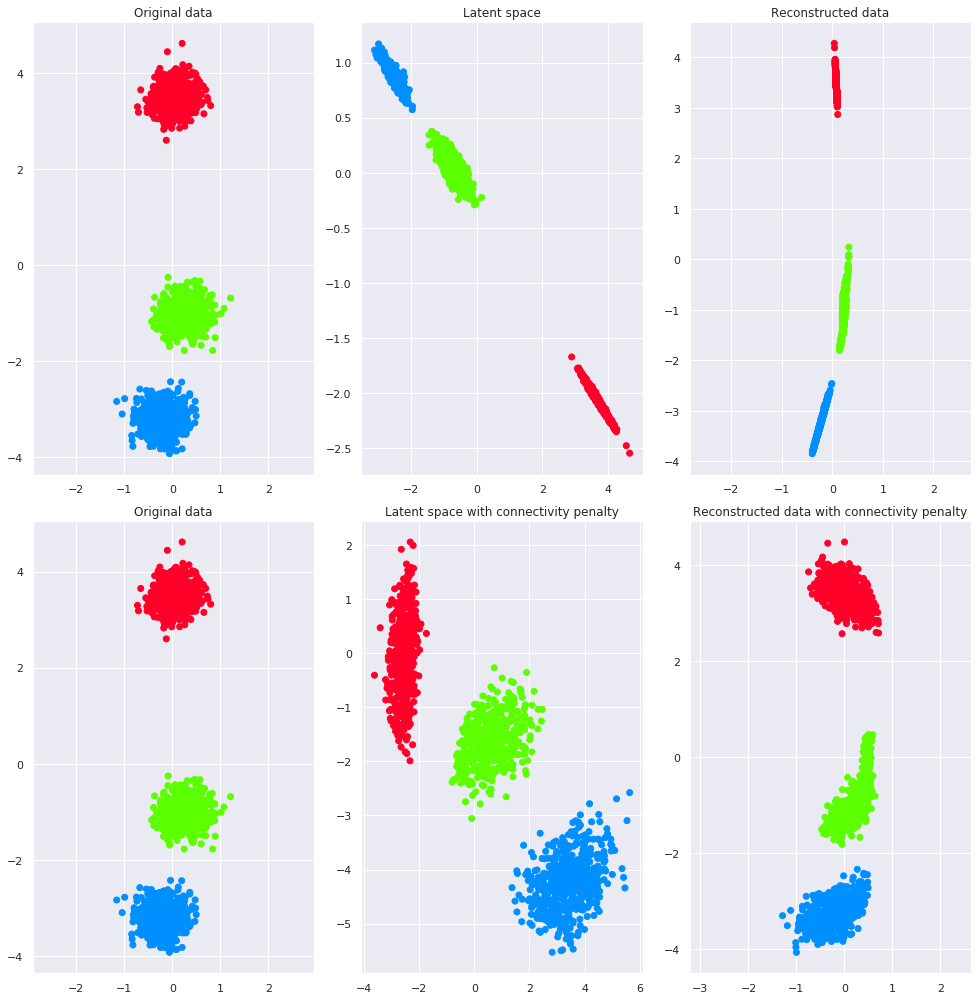

[0.0007704401, 0.038385445949154905, 2.8522375]
[0.00030751099, 0.015447127970160445, 3.1082876]
[0.001431003, 0.06812151501065815, 1.5779403]


In [5]:
fig, axes = plt.subplots(figsize=(14, 14), nrows=2, ncols=3)

ax = axes[0, 0]
ax.scatter(data[:, 0], data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Original data')

ax = axes[0, 1]
latent_space_no_penalty = model_no_penalty.autoencoder.encoder(data).data
ax.scatter(latent_space_no_penalty[:, 0], latent_space_no_penalty[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Latent space')

ax = axes[0, 2]
reconstructed_data = model_no_penalty.autoencoder(data).data
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Reconstructed data')


ax = axes[1, 0]
ax.scatter(data[:, 0], data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Original data')

ax = axes[1, 1]
latent_space_penalty = model_penalty.autoencoder.encoder(data).data
ax.scatter(latent_space_penalty[:, 0], latent_space_penalty[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Latent space with connectivity penalty')

ax = axes[1, 2]
reconstructed_data = model_penalty.autoencoder(data).data
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_aspect('equal', 'datalim')
ax.set_title('Reconstructed data with connectivity penalty')

plt.tight_layout()
plt.show()

print(barcode_stats(data))
print(barcode_stats(latent_space_no_penalty))
print(barcode_stats(latent_space_penalty))

### Generate 3D Gaussian mixture data

In [6]:
# dimension
d = 3
# number of Gaussians in the mixture
K = 3
# number of points per cluster
N = 500

# for plotting
cmap = plt.get_cmap('gist_rainbow')
cNorm  = mpl.colors.Normalize(vmin=0, vmax=K)
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
colors = scalarMap.to_rgba(range(K))

data = []
labels = []
# random centroids in [-5,5]x[-5, 5]
means = 10*(np.random.rand(K, d)-0.5)
# random covariances
covs = 0.1*np.random.rand(K, d, d)
for k in range(K):
    # this is indeed a covariance matrix
    covs[k] = 0.3*np.dot(covs[k], covs[k].T)+0.7*0.1*np.eye(d)
    data.append([np.random.multivariate_normal(means[k], covs[k], N)])
    labels.append([k,]*N)
    
data = torch.FloatTensor(np.concatenate(data, axis=1).squeeze())
labels = np.array(labels).flatten()

### Model setup

In [7]:
config_layers = {
    'type': 'mlp',
    'input_size': data.shape[1],
    'hidden_size_encoder': 20,
    'hidden_size_decoder': 20,
    'emb_size': 2,
}

use_cuda = False
eta = 2.0
tol = 1e-4
lr = 0.001
batch_size = 50
n_epochs = 10

### Training

In [8]:
model_no_penalty = Model(config_layers, 
                         eta=eta,
                         tol=tol,
                         lr=lr,
                         batch_size=batch_size,
                         use_cuda=use_cuda,
                         connectivity_penalty=0.0,
                        )

model_no_penalty.train(data, n_epochs)
# torch.save(model_no_penalty.state_dict(), 'gauss_3d_{}_epochs_no_penalty.pt'.format(n_epochs))

model_penalty = Model(config_layers, 
                      eta=eta,
                      tol=tol,
                      lr=lr,
                      batch_size=batch_size,
                      use_cuda=use_cuda,
                      connectivity_penalty=1.0,
                     )

model_penalty.train(data, n_epochs)
# torch.save(model_penalty.state_dict(), 'gauss_3d_{}_epochs_penalty.pt'.format(n_epochs))

Epoch : 1/10: 100%|█| 30.0/30.0 [00:00<00:00, 249it/s, connectivity loss=0, reconstruction loss=7.61]
Epoch : 2/10: 100%|█| 30.0/30.0 [00:00<00:00, 287it/s, connectivity loss=0, reconstruction loss=6.06]
Epoch : 3/10: 100%|█| 30.0/30.0 [00:00<00:00, 352it/s, connectivity loss=0, reconstruction loss=3.58]
Epoch : 4/10: 100%|█| 30.0/30.0 [00:00<00:00, 333it/s, connectivity loss=0, reconstruction loss=1.62]
Epoch : 5/10: 100%|█| 30.0/30.0 [00:00<00:00, 272it/s, connectivity loss=0, reconstruction loss=1.01]
Epoch : 6/10: 100%|█| 30.0/30.0 [00:00<00:00, 198it/s, connectivity loss=0, reconstruction loss=0.734]
Epoch : 7/10: 100%|█| 30.0/30.0 [00:00<00:00, 249it/s, connectivity loss=0, reconstruction loss=0.451]
Epoch : 8/10: 100%|█| 30.0/30.0 [00:00<00:00, 272it/s, connectivity loss=0, reconstruction loss=0.224] 
Epoch : 9/10: 100%|█| 30.0/30.0 [00:00<00:00, 245it/s, connectivity loss=0, reconstruction loss=0.0972]
Epoch : 10/10: 100%|█| 30.0/30.0 [00:00<00:00, 245it/s, connectivity loss=0,

### Results

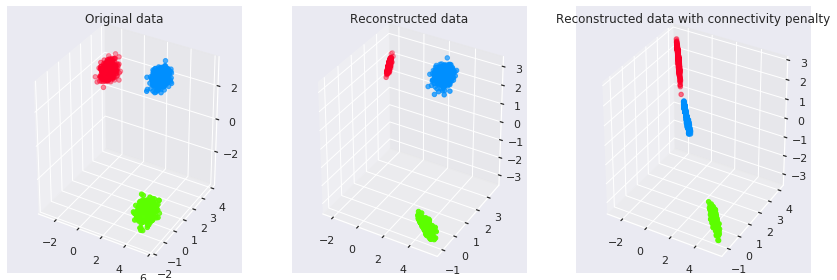

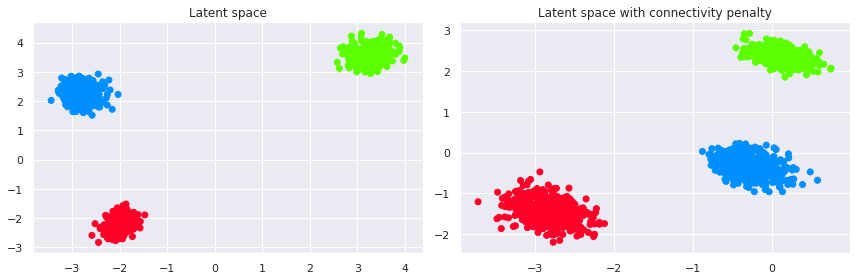

[0.0058199805, 0.09993547944723566, 5.088831]
[0.00065657444, 0.034062345478040046, 4.7422633]
[0.0013945119, 0.030662742752166808, 1.7716835]


In [9]:
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(data[:, 0], data[:, 1],  data[:, 2], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Original data')

ax = fig.add_subplot(132, projection='3d')
reconstructed_data = model_no_penalty.autoencoder(data).data
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1],  reconstructed_data[:, 2], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Reconstructed data')

ax = fig.add_subplot(133, projection='3d')
reconstructed_data = model_penalty.autoencoder(data).data
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1],  reconstructed_data[:, 2], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Reconstructed data with connectivity penalty')

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(121)
latent_space_no_penalty = model_no_penalty.autoencoder.encoder(data).data
ax.scatter(latent_space_no_penalty[:, 0], latent_space_no_penalty[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Latent space')

ax = fig.add_subplot(122)
latent_space_penalty = model_penalty.autoencoder.encoder(data).data
ax.scatter(latent_space_penalty[:, 0], latent_space_penalty[:, 1], c=labels, cmap=mpl.colors.ListedColormap(colors))
ax.set_title('Latent space with connectivity penalty')

plt.tight_layout()
plt.show()

print(barcode_stats(data))
print(barcode_stats(latent_space_no_penalty))
print(barcode_stats(latent_space_penalty))